<a href="https://colab.research.google.com/github/karsarobert/Deep-Learning-2022/blob/main/08/PTE_DL8_AGE_PRED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning gyakorlat


## 8. gyakorlat: konvolúciós hálózat
### 2022. október 26.

# Életkor meghatározása fotó alapján

Az XYZ szupermarketlánc szeretné megvizsgálni, hogy az adattudomány segíthet-e nekik az alkoholtörvények betartásában, hogy ne adjanak el alkoholt kiskorúaknak. Arra kérik, hogy végezze el ezt a feladatot, ezért amikor munkához lát, tartsa szem előtt a következőket:
- Az üzletek kamerákkal vannak felszerelve a pénztárnál, amelyek akkor lépnek működésbe, amikor valaki alkoholt vásárol;
- Számítógépes látásmódok segítségével egy fénykép alapján meg lehet állapítani egy személy életkorát;

### 0.1 Cél
A feladat tehát egy olyan modell létrehozása és kiértékelése, amely mély neurális hálózat segítségével ellenőrzi az emberek életkorát.

forrás: https://www.kaggle.com/code/amanabdullayev/age-prediction-from-photo-using-cnn-resnet50/notebook

## 1. Adatok betöltése és feltárása

In [ ]:
#necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!gdown --id 15G625qvDsp8wDgydwaiAgAXzfSq3I7NS
!gdown --id 1rXFvWYz6UCv4aD_YT741wbthqm_BBnqY

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=15G625qvDsp8wDgydwaiAgAXzfSq3I7NS
To: /content/labels.csv
100% 113k/113k [00:00<00:00, 68.6MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1rXFvWYz6UCv4aD_YT741wbthqm_BBnqY
To: /content/final_files.zip
100% 239M/239M [00:05<00:00, 41.8MB/s]


In [ ]:
!unzip -q final_files.zip

In [ ]:
#load labels.csv and observe it
labels = pd.read_csv('labels.csv')
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


> Nézzük meg a korfát

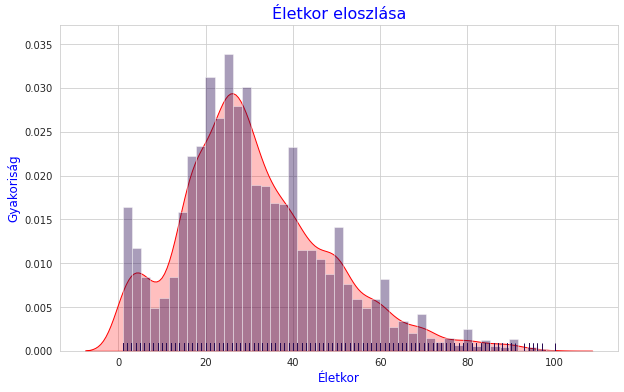

In [ ]:
plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
sns.set_palette('inferno')
sns.distplot(labels['real_age'], rug=True, kde_kws={'shade':True, 'color':'r'})
plt.xlabel('Életkor', fontsize=12, color='b')
plt.ylabel('Gyakoriság', fontsize=12, color='b')
plt.title('Életkor eloszlása', fontsize=16, color='b')
plt.show()

* Amint a fenti ábrán láthatjuk, különböző korú emberek képei vannak. A képek többsége azonban 20-40 éves emberekhez tartozik. És elég sok aranyos babafotónk is van (kevesebb, mint 10).*.

Tekintettel arra, hogy a képfájlok száma meglehetősen nagy, célszerű elkerülni, hogy egyszerre olvassuk be őket, mivel ez nagymértékben fogyasztaná a számítási erőforrásokat. Ezért a **ImageDataGenerator** generátort fogjuk használni: a Kerasból származó osztály, amely egy könyvtárban található képek és címkék (például osztályozáshoz használt osztály) alapján képeket és címkéket tartalmazó kötegeket képez.

In [ ]:
train_datagen = ImageDataGenerator(
            rescale=1 / 255
            )

#flow_from_dataframe módszert használjuk  a képek betöltésére a könyvtárból és a címkék betöltésére az adatkeretből
train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe = labels,
    directory='final_files',
    x_col="file_name", 
    y_col="real_age",
    #regressziót végzünk, ezért a class_mode-ot 'raw'-ra állítjuk be
    class_mode="raw",
    #minden képet azonos pixelméretűvé konvertálni, a neurális hálózatokhoz minden képnek hasonló méretűnek kell lennie.
    target_size=(224,224),
    #a képeket kötegenként töltjük be (minden alkalommal 32 képet töltünk be)
    batch_size=32,
    seed=12345,
    )

Found 7591 validated image filenames.


In [ ]:
#kérünk egy köteget az adatgenerátorunkból és megjelenítjük benne a képeket
features, target = next(train_datagen_flow)

# 16 kép megjelenítése
fig = plt.figure(figsize=(12,12))
for i in range(32):
    fig.add_subplot(4, 8, i+1)
    plt.imshow(features[i])
    plt.title(f'{target[i]}')
	# távolítsuk el a tengelyeket és helyezzük a képeket közelebb egymáshoz a kompaktabb kimenet érdekében
    plt.xticks([])
    plt.yticks([])
    plt.suptitle('Képek a valódi életkorral',  y=0.9,fontsize=16, color='b')
    plt.tight_layout()

Amint láthatjuk, az adathalmazunk különböző arcképeket tartalmaz. Néhányat közülük elforgatott, eltolt stb. egy kicsit.Betanítunk egy modellt.

## 2. Defining necessary functions for neural network

In [ ]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1 / 255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset = 'training',
        seed=12345)

    return train_gen_flow


def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    labels = pd.read_csv(path + 'labels.csv')
    validation_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    test_gen_flow = validation_datagen.flow_from_dataframe(
    dataframe = labels,
    directory=path +'final_files/',
    x_col="file_name",
    y_col="real_age", 
    class_mode="raw", 
    target_size=(224,224), 
    batch_size=32,
    subset = "validation",
    seed=12345,
    )

    return test_gen_flow


def create_model(input_shape):
    
    """
    It defines the model
    """
    # a ResNet50 architektúrát fogjuk használni
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    
    model.add(Dropout(0.2))
    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(1)) #, activation='relu'
    optimizer = Adam(lr=0.0003)
    model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])
    print(model.summary())

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    model.fit(train_data, validation_data=test_data, batch_size=batch_size, 
              epochs=epochs, steps_per_epoch=steps_per_epoch, 
              validation_steps=validation_steps, verbose=2)

    return model

## Calling functions

In [ ]:
#assign data directory
path = ''

In [ ]:
#load training and testing (actually this is validation data set)
train_data = load_train(path)
test_data = load_test(path)

#build a model
model = create_model(input_shape = (224, 224, 3))

Found 5694 validated image filenames.
Found 1897 validated image filenames.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 2048)        0         
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________
None


> A modell kiképzése hosszú időt vehet igénybe, különösen GPU nélkül. A ResNet50 modellben több mint 23 millió betanítható paraméter van. Ez az oka annak, hogy a GPU-platform nélküli használata nagyon-nagyon hosszú várakozási időt okozna a modell betanítására, még akkor is, ha az már előre betanított.

In [ ]:
#train the model
model = train_model(model, train_data, test_data)

Epoch 1/20
178/178 - 81s - loss: 10.5371 - mae: 10.5371 - val_loss: 33.7371 - val_mae: 33.7371 - 81s/epoch - 456ms/step
Epoch 2/20
178/178 - 73s - loss: 7.9673 - mae: 7.9673 - val_loss: 13.5528 - val_mae: 13.5528 - 73s/epoch - 412ms/step
Epoch 3/20
178/178 - 73s - loss: 6.6424 - mae: 6.6424 - val_loss: 13.6367 - val_mae: 13.6367 - 73s/epoch - 411ms/step
Epoch 4/20
178/178 - 74s - loss: 5.9141 - mae: 5.9141 - val_loss: 8.4315 - val_mae: 8.4315 - 74s/epoch - 417ms/step
Epoch 5/20
178/178 - 73s - loss: 5.3800 - mae: 5.3800 - val_loss: 7.6223 - val_mae: 7.6223 - 73s/epoch - 410ms/step
Epoch 6/20
178/178 - 74s - loss: 4.9826 - mae: 4.9826 - val_loss: 6.9846 - val_mae: 6.9846 - 74s/epoch - 413ms/step
Epoch 7/20
178/178 - 73s - loss: 4.5309 - mae: 4.5309 - val_loss: 7.3387 - val_mae: 7.3387 - 73s/epoch - 411ms/step
Epoch 8/20
178/178 - 73s - loss: 4.2695 - mae: 4.2695 - val_loss: 8.7559 - val_mae: 8.7559 - 73s/epoch - 412ms/step
Epoch 9/20
178/178 - 73s - loss: 3.9415 - mae: 3.9415 - val_loss

## Elég jó MAE-t értünk el, amely a személy életkorát $\pm$ 6.4 $\pm$ értékkel tudja megjósolni. 

## Egyébként az [egy cikk erről az adatkészletről](http://people.ee.ethz.ch/~timofter/publications/Agustsson-FG-2017.pdf), amivel dolgozunk, a legalacsonyabb MAE érték, amit elértek, 5,4. Ezt a cikket 2017-ben publikálta az ETH Computer Vision researhcer. Mi is elég jól teljesítettünk, hiszen az 5,4-es értékhez képest 6,4-es MAE értéket kaptunk.

Tehát a mi XYZ üzletünk, most már használhatja ezt a modellt csak arra, hogy azonosítsa az alkoholos termékeket vásárló személy életkorát.

--2022-10-25 16:50:00--  https://img.freepik.com/free-photo/cute-happy-boy-with-yellow-tshirt_58702-7711.jpg
Resolving img.freepik.com (img.freepik.com)... 104.117.232.154, 2600:1409:9800:981::312e, 2600:1409:9800:98d::312e
Connecting to img.freepik.com (img.freepik.com)|104.117.232.154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35921 (35K) [image/jpeg]
Saving to: ‘cute-happy-boy-with-yellow-tshirt_58702-7711.jpg’

cute-happy-boy-with 100%[===================>]  35.08K   223KB/s    in 0.2s    

2022-10-25 16:50:01 (223 KB/s) - ‘cute-happy-boy-with-yellow-tshirt_58702-7711.jpg’ saved [35921/35921]



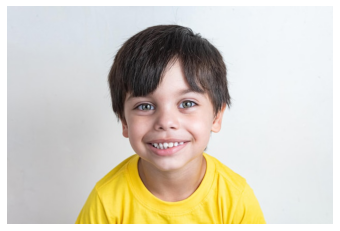

In [ ]:
import matplotlib.image as mpimg
!wget https://img.freepik.com/free-photo/cute-happy-boy-with-yellow-tshirt_58702-7711.jpg
face = mpimg.imread("cute-happy-boy-with-yellow-tshirt_58702-7711.jpg")
plt.imshow(face)
plt.axis(False);

In [ ]:
def load_and_prep_image(filename, img_shape=224):
  img = tf.io.read_file(filename)
  img = tf.image.decode_image(img, channels=3) #tensor formatum
  img = tf.image.resize(img, size = [img_shape, img_shape])
  img = img/255.
  img = tf.expand_dims(img, axis=0)
  return img


In [ ]:
face = load_and_prep_image('cute-happy-boy-with-yellow-tshirt_58702-7711.jpg')

In [ ]:
pred = model.predict(face)

1/1 [==============================] - 0s 24ms/step


In [ ]:
pred

array([[12.188922]], dtype=float32)

#Házi feladat!
##Projekt feladat
Töltsünk le az internetről a megismert módszerrel legalább 3 osztályt érintően képeket, majd azokra transfer learning segítségével tanítsunk be egy modellt, és értékeljük azt pontosság, loss figyelembevételével mind a tanító, mind a validációs halmazon.
A modellt mentsük el, majd egy másik notebookban töltsük be a modellt és GRADIO
segítségével publikáljuk ki azt, és az osztályok száma szerinti képpel teszteljük a működését. Határidő: 2022.11.09